**Impact of class imbalances comparing no means of balancing, dumping of samples of majority class and interpolation of samples for minority class**

In [1]:
# import libraries
import numpy as np
import pandas as pd
import plotly.express as px
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.utils import resample
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, log_loss
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from imblearn.over_sampling import SMOTE
import time

In [2]:
# visualize data
def visualize(hospital):
  'visualize the immo data in an interactive 3D plot'
  hospital_death = hospital[hospital.hospital_death==1]
  no_hospital_death = hospital[hospital.hospital_death==0]

  fig = px.scatter_3d(hospital, x="d1_spo2_min", y="d1_sysbp_min", z="d1_temp_min", color="hospital_death", size_max=18, color_discrete_map={0:"blue", 1:"orange"})
  fig.update_traces(marker=dict(size=3))
  fig.update_layout(autosize=False, width=800, height=500)
  # , scene=dict(
  #                     xaxis = dict(range=[0,500],),
  #                     yaxis = dict(range=[1850,2020],),
  #                     zaxis = dict(range=[0,30],)
  #                 ))
  fig.show()

In [3]:
# import apartment data
# already cleaned i.e. removal of NaN rows
hospital = pd.read_csv("https://raw.githubusercontent.com/pejokoe/sumsem/master/sfml/hosp_cleaned.csv")
hospital = hospital.fillna(hospital.mean())

# perform feature selection
x_new = SelectKBest(f_classif, k=3).fit_transform(hospital.drop(columns=["hospital_death"]), hospital.hospital_death)
print(x_new)
# column duplication becomes apparent -> drop column
hospital = hospital.drop(columns="d1_sysbp_noninvasive_min") 
# perform feature selection
x_new = SelectKBest(f_classif, k=3).fit_transform(hospital.drop(columns=["hospital_death"]), hospital.hospital_death)
print(x_new)
# checking x_new leads to the conclusion that the columns d1_spo2_min (patient's lowest peripheral oxygen day 1),
# d1_sysbp_min (patient's lowest systolic blood pressure day 1)
# and d1_temp_min (patient's lowest core temperature day 1)

hospital = hospital[["d1_spo2_min", "d1_sysbp_min", "d1_temp_min", "hospital_death"]].sample(10000)
print(hospital.head())
# check for class imbalance
hospital_death = hospital[hospital.hospital_death==1]
no_hospital_death = hospital[hospital.hospital_death==0]
print(" hospital hospital_death: ", len(hospital_death))
print(" hospital no_hospital_death: ", len(no_hospital_death))
print("Imbalance: Minority class makes %.2f %% of all samples." % (len(hospital_death)/(len(hospital_death) + len(no_hospital_death)) * 100))


[[ 74.  73.  73.]
 [ 70.  67.  67.]
 [ 91. 105. 105.]
 ...
 [ 81.  75.  75.]
 [ 83. 111. 111.]
 [ 91.  85.  85.]]
[[ 74.   73.   37.2]
 [ 70.   67.   35.1]
 [ 91.  105.   36.7]
 ...
 [ 81.   75.   35.8]
 [ 83.  111.   36.3]
 [ 91.   85.   36. ]]
       d1_spo2_min  d1_sysbp_min  d1_temp_min  hospital_death
66138         91.0          86.0        32.05               1
15197         92.0          92.0        36.50               0
89987         94.0          91.0        36.10               0
59840         91.0         104.0        36.40               0
25899         94.0          84.0        32.70               0
 hospital hospital_death:  838
 hospital no_hospital_death:  9162
Imbalance: Minority class makes 8.38 % of all samples.


In [4]:
# visualize on a randomly sampled subset to allow better visual interpretation
visualize(hospital.sample(1000))

In [5]:
# # as imbalance is mild, artificially increase it to 90 % by dumping hospital_death hospital
# hospital_death = hospital_death.sample(int(len(no_hospital_death) * 0.1))
# hospital = pd.concat((hospital_death, no_hospital_death), axis=0)
# hospital.reset_index(drop=1)

# # check again for class imbalance
# hospital_death = hospital[hospital.hospital_death==1]
# no_hospital_death = hospital[hospital.hospital_death==0]
# print("After artificial class imbalance increase:")
# print(" hospital hospital_death: ", len(hospital_death))
# print(" hospital no_hospital_death: ", len(no_hospital_death))

In [6]:
# # visualize after class imbalancing
# visualize(hospital.sample(500))

In [7]:
# split data into training and test set and input and target
xTrain, xTest, yTrain, yTest = train_test_split(hospital[["d1_spo2_min", "d1_temp_min", "d1_sysbp_min"]], hospital["hospital_death"], test_size = 0.1, shuffle=1, random_state=0)
print(xTrain[:5], yTrain[:5])

       d1_spo2_min  d1_temp_min  d1_sysbp_min
69581         98.0         36.6         143.0
51806         94.0         36.8         110.0
45367         82.0         36.1          72.0
3077          94.0         36.4         109.0
13884         94.0         36.5         104.0 69581    0
51806    0
45367    0
3077     0
13884    0
Name: hospital_death, dtype: int64


       d1_spo2_min  d1_temp_min  d1_sysbp_min  hospital_death
722      93.000000    36.200000    102.000000               0
9539     88.000000    36.390860     97.272850               1
3993     90.000000    36.000000    123.000000               0
15582    70.016985    36.986412     74.016985               1
7772     85.000000    36.400000    122.000000               0


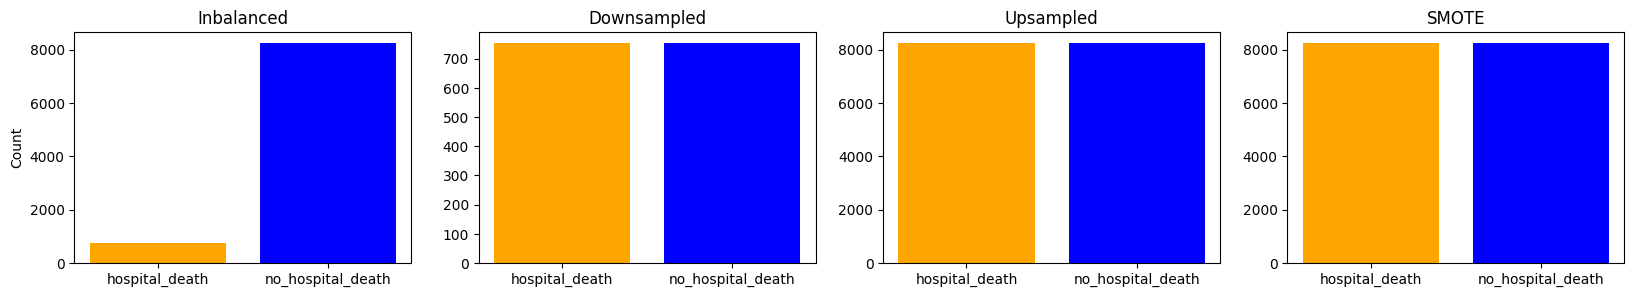

In [8]:
# balance classes 
# combine input and target for sampling
training_points = pd.concat((xTrain, yTrain), axis=1)
# data seperated by class
hospital_death = training_points[training_points.hospital_death==1]
no_hospital_death = training_points[training_points.hospital_death==0]
fig, axs = plt.subplots(1, 4)
fig.set_figheight(3)
fig.set_figwidth(20)

# method 0: use inbalanced training set without balancing measures
axs[0].bar(0.5, len(hospital_death), color="orange", label="hospital_death")
axs[0].bar(1.5, len(no_hospital_death), color="blue", label="no_hospital_death")
axs[0].set_title("Inbalanced")
axs[0].set_ylabel("Count")
axs[0].set_xticks([0.5, 1.5], ["hospital_death", "no_hospital_death"])

# method 1: discarding random sampels from majority class
no_hospital_death_downsampling = no_hospital_death.sample(len(hospital_death))
tp_downsampling = pd.concat((hospital_death, no_hospital_death_downsampling), axis=0).sample(frac=1)
axs[1].bar(0.5, len(hospital_death), color="orange", label="hospital_death")
axs[1].bar(1.5, len(no_hospital_death_downsampling), color="blue", label="no_hospital_death")
axs[1].set_title("Downsampled")
axs[1].set_xticks([0.5, 1.5], ["hospital_death", "no_hospital_death"])

# method 3: upsampling duplicating random samples (multiple times)
hospital_death_upsampling = resample(hospital_death, replace=1, n_samples=len(no_hospital_death))
tp_upsampling = pd.concat((hospital_death_upsampling, no_hospital_death), axis=0).sample(frac=1)
axs[2].bar(0.5, len(hospital_death_upsampling), color="orange", label="hospital_death")
axs[2].bar(1.5, len(no_hospital_death), color="blue", label="no_hospital_death")
axs[2].set_title("Upsampled")
axs[2].set_xticks([0.5, 1.5], ["hospital_death", "no_hospital_death"])

# method 4: Generate synthetic samples using SMOTE
smote = SMOTE(random_state=0)
x_smote, y_smote = (smote.fit_resample(training_points[["d1_spo2_min", "d1_temp_min", "d1_sysbp_min"]], training_points.hospital_death))
tp_smote = pd.concat((x_smote, y_smote), axis=1).sample(frac=1)
print(tp_smote.head())
axs[3].bar(0.5, len(tp_smote[tp_smote.hospital_death==1]), color="orange", label="hospital_death")
axs[3].bar(1.5, len(tp_smote[tp_smote.hospital_death==0]), color="blue", label="no_hospital_death")
axs[3].set_title("SMOTE")
axs[3].set_xticks([0.5, 1.5], ["hospital_death", "no_hospital_death"])

In [9]:
# binarize function
def binarize(to_binarize):
  if to_binarize==0:
    return 0
  else:
    return 1

In [10]:
# scale all training inputs, binarize hospital_death

# no measure
scaler_no_measure = MinMaxScaler()
x_no_measure = training_points[["d1_spo2_min", "d1_temp_min", "d1_sysbp_min"]]
x_no_measure = scaler_no_measure.fit_transform(x_no_measure)
y_no_measure = training_points["hospital_death"].apply(binarize)

# downsampling
scaler_downsampling = MinMaxScaler()
x_downsampling = tp_downsampling[["d1_spo2_min", "d1_temp_min", "d1_sysbp_min"]]
x_downsampling = scaler_downsampling.fit_transform(x_downsampling)
y_downsampling = tp_downsampling["hospital_death"].apply(binarize)

# upsampling
scaler_upsampling = MinMaxScaler()
x_upsampling = tp_upsampling[["d1_spo2_min", "d1_temp_min", "d1_sysbp_min"]]
x_upsampling = scaler_upsampling.fit_transform(x_upsampling)
y_upsampling = tp_upsampling["hospital_death"].apply(binarize)

# smote
scaler_smote = MinMaxScaler()
x_smote = tp_smote[["d1_spo2_min", "d1_temp_min", "d1_sysbp_min"]]
x_smote = scaler_smote.fit_transform(x_smote)
y_smote = tp_smote["hospital_death"].apply(binarize)

In [11]:
# first machine learning algorithm: SVM
# using rbf kernel as it is considered most powerful (default parameter)
svm_no_measure = SVC(class_weight="balanced")
svm_downsampling = SVC(class_weight="balanced")
svm_upsampling = SVC(class_weight="balanced")
svm_smote = SVC(class_weight="balanced")

times = [time.time()]
svm_no_measure = svm_no_measure.fit(x_no_measure, y_no_measure)
times.append(time.time())
svm_downsampling = svm_downsampling.fit(x_downsampling, y_downsampling)
times.append(time.time())
svm_upsampling = svm_upsampling.fit(x_upsampling, y_upsampling)
times.append(time.time())
svm_smote = svm_smote.fit(x_smote, y_smote)
times.append(time.time())

In [12]:
print("SVM no measure training time: %f s" % (times[1] - times[0]))
print("SVM downsampled training time: %f s" % (times[2] - times[1]))
print("SVM upsampled training time: %f s" % (times[3] - times[2]))
print("SVM smote training time: %f s" % (times[4] - times[3]))

SVM no measure training time: 3.017272 s
SVM downsampled training time: 0.050806 s
SVM upsampled training time: 7.446229 s
SVM smote training time: 7.283207 s


In [13]:
# compare results using precision, recall and confusion matrix
# scale test set with corresponding scaler
xTest_no_measure = scaler_no_measure.transform(xTest)
xTest_downsampling = scaler_downsampling.transform(xTest)
xTest_upsampling = scaler_upsampling.transform(xTest)
xTest_smote = scaler_smote.transform(xTest)
# use corresponding svm to predict
yPred_no_measure = svm_no_measure.predict(xTest_no_measure)
yPred_downsampling = svm_downsampling.predict(xTest_downsampling)
yPred_upsampling = svm_upsampling.predict(xTest_upsampling)
yPred_smote = svm_smote.predict(xTest_smote)

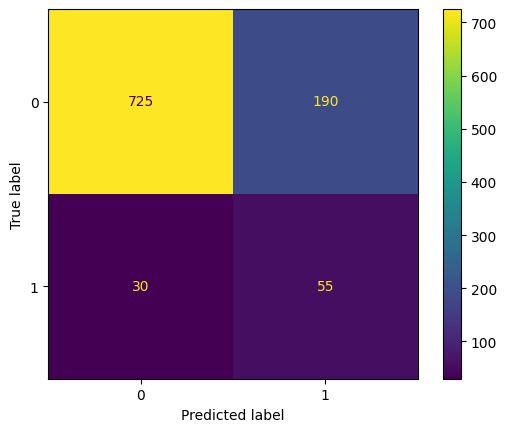

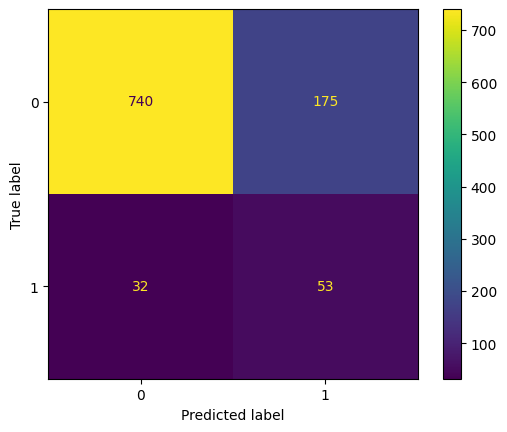

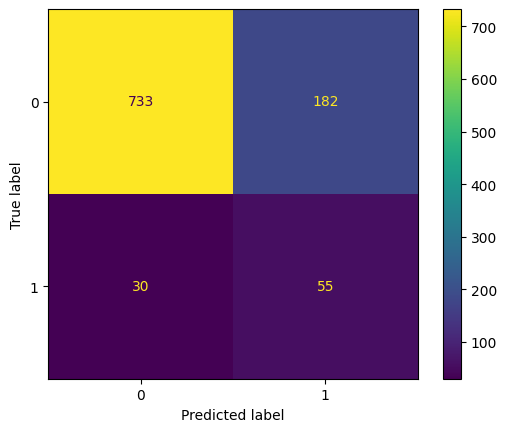

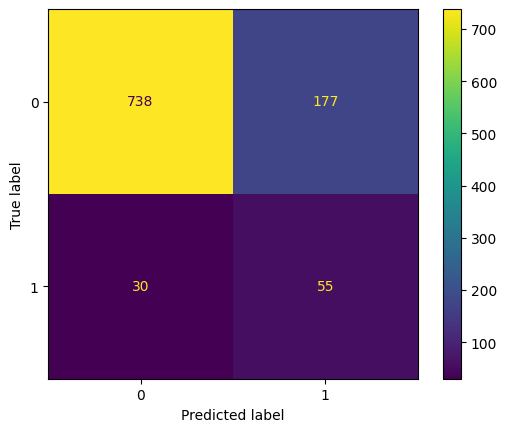

In [14]:
yTest = yTest.apply(binarize)
# confusion matrices
cm_no_measure = confusion_matrix(yTest, yPred_no_measure)
ConfusionMatrixDisplay(cm_no_measure).plot()

cm_downsampling = confusion_matrix(yTest, yPred_downsampling)
ConfusionMatrixDisplay(cm_downsampling).plot()

cm_upsampling = confusion_matrix(yTest, yPred_upsampling)
ConfusionMatrixDisplay(cm_upsampling).plot()

cm_smote = confusion_matrix(yTest, yPred_smote)
ConfusionMatrixDisplay(cm_smote).plot()


In [15]:
# precision and recall
p_no_measure = precision_score(yTest, yPred_no_measure)
r_no_measure = recall_score(yTest, yPred_no_measure)
f1_no_measure = f1_score(yTest, yPred_no_measure)
print("No measure precision: %.2f" % p_no_measure)
print("No measure recall: %.2f" % r_no_measure)
print("No measure f1 score: %.2f\n" % f1_no_measure)

p_downsampling = precision_score(yTest, yPred_downsampling)
r_downsampling = recall_score(yTest, yPred_downsampling)
f1_downsampling = f1_score(yTest, yPred_downsampling)
print("downsampling precision: %.2f" % p_downsampling)
print("downsampling recall: %.2f" % r_downsampling)
print("downsampling f1 score: %.2f\n" % f1_no_measure)

p_upsampling = precision_score(yTest, yPred_upsampling)
r_upsampling = recall_score(yTest, yPred_upsampling)
f1_upsampling = f1_score(yTest, yPred_upsampling)
print("upsampling precision: %.2f" % p_upsampling)
print("upsampling recall: %.2f" % r_upsampling)
print("upsampling f1 score: %.2f\n" % f1_upsampling)

p_smote = precision_score(yTest, yPred_smote)
r_smote = recall_score(yTest, yPred_smote)
f1_smote = f1_score(yTest, yPred_smote)
print("smote precision: %.2f" % p_smote)
print("smote recall: %.2f" % r_smote)
print("smote f1 score: %.2f\n" % f1_smote)

No measure precision: 0.22
No measure recall: 0.65
No measure f1 score: 0.33

downsampling precision: 0.23
downsampling recall: 0.62
downsampling f1 score: 0.33

upsampling precision: 0.23
upsampling recall: 0.65
upsampling f1 score: 0.34

smote precision: 0.24
smote recall: 0.65
smote f1 score: 0.35



In [32]:
def cross_validation(model, input, target):
    'perform k-fold cross validation, return training and validation log_loss'
    kf = KFold(5, shuffle = True, random_state = 0)
    losses = [[], []]
    for train_ind, val_ind in kf.split(input, target):
        model.fit(input[train_ind], target[train_ind])
        losses[0].append(log_loss(model.predict(input[train_ind]), target[train_ind]))
        losses[1].append(log_loss(model.predict(input[val_ind]), target[val_ind]))
    return [np.mean(losses[0]), np.mean(losses[1])]

def trees(xTrain, yTrain):
    'experimental setup to find the best depth for the tree of all three target variables'
    start = 5
    end = 20
    no_measure = []
    down = []
    up = []
    smote = []
    for depth in range(start, end, 3):
        no_measure_tree = DecisionTreeClassifier(max_depth=depth)
        downsampling_tree = DecisionTreeClassifier(max_depth=depth)
        upsampling_tree = DecisionTreeClassifier(max_depth=depth)
        smote_tree = DecisionTreeClassifier(max_depth=depth)
        no_measure.extend(cross_validation(no_measure_tree, xTrain[0], yTrain[0].to_numpy()))
        down.extend(cross_validation(downsampling_tree, xTrain[1], yTrain[1].to_numpy()))
        up.extend(cross_validation(upsampling_tree, xTrain[2], yTrain[2].to_numpy()))
        smote.extend(cross_validation(smote_tree, xTrain[3], yTrain[3].to_numpy()))
    fig, axis = plt.subplots(1, 4)
    axis[0].plot(range(start, end, 3), no_measure[::2], label="Training")
    axis[0].plot(range(start, end, 3), no_measure[1::2], label="Validation")
    axis[0].set_title("No_measure")
    axis[0].set_xlabel("Depth of tree")
    axis[0].set_ylabel("log_loss")

    axis[1].plot(range(start, end, 3), down[::2])
    axis[1].plot(range(start, end, 3), down[1::2])
    axis[1].set_title("Downsampling")
    axis[1].set_xlabel("Depth of tree")

    axis[2].plot(range(start, end, 3), up[::2])
    axis[2].plot(range(start, end, 3), up[1::2])
    axis[2].set_title("Upsampling")
    axis[2].set_xlabel("Depth of tree")

    axis[3].plot(range(start, end, 3), up[::2])
    axis[3].plot(range(start, end, 3), up[1::2])
    axis[3].set_title("Smote")
    axis[3].set_xlabel("Depth of tree")

    axis[0].grid()
    axis[1].grid()
    axis[2].grid()
    axis[3].grid()
    plt.legend()
    plt.show()

<class 'numpy.ndarray'>


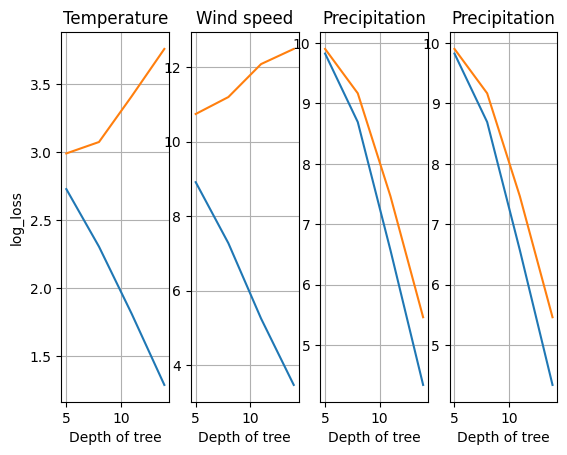

In [33]:
# second machine learning algorithm: decision tree regressor
# use validation to find best tree depth
print(type(x_no_measure))
trees([x_no_measure, x_downsampling, x_upsampling, x_smote], [y_no_measure, y_downsampling, y_upsampling, y_smote])


In [ ]:
svm_no_measure = SVC(class_weight="balanced")
svm_downsampling = SVC(class_weight="balanced")
svm_upsampling = SVC(class_weight="balanced")
svm_smote = SVC(class_weight="balanced")

times = [time.time()]
svm_no_measure = svm_no_measure.fit(x_no_measure, y_no_measure)
times.append(time.time())
svm_downsampling = svm_downsampling.fit(x_downsampling, y_downsampling)
times.append(time.time())
svm_upsampling = svm_upsampling.fit(x_upsampling, y_upsampling)
times.append(time.time())
svm_smote = svm_smote.fit(x_smote, y_smote)
times.append(time.time())